# Natural Language Processing with Deep Learning

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

**There are 4 tasks in the assignment. By completing task 1 and 2 and 3 you get 0.5 points. For Task 4 you get 0.5. as well**

In [1]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
data = pd.read_csv("/content/gdrive/My Drive/Train_rev1.zip", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

15843    Job Title: Senior Analyst – Secured Acquisitio...
42537    In collaboration with UNEP JOB DESCRIPTION Job...
30263    Graduate Trainee Business Intelligence Sales T...
Name: FullDescription, dtype: object

In [5]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
152327,70776343,PA/Office Manager,PA/Office Manager – Maternity Cover We have a ...,London,London,full_time,contract,Hampstead Bureau,Admin Jobs,"From 28,000 to 32,000 per year",30000,SecsintheCity,10.308986
43306,68496224,Business Analyst,Support Business Analysis Manager in providing...,Somerset Bristol BS483,West Town,NaN,permanent,Michael Page Technology,IT Jobs,35000.00 GBP Annual,35000,jobserve.com,10.463132
138591,70455638,AVP Controls Assurance Manager Canary Wharf ...,A leading Global Blue Chip Bank is looking to ...,City of London,The City,full_time,permanent,Real Staffing,Accounting & Finance Jobs,"45000 - 55000 per annum + 3,550 LTA",50000,careersinaudit.com,10.819798


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [6]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [7]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
# <YOUR CODE HERE>
for col in text_columns:
    for descr in data[col]:
        words = descr.split(' ')
        token_counts.update(words)

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

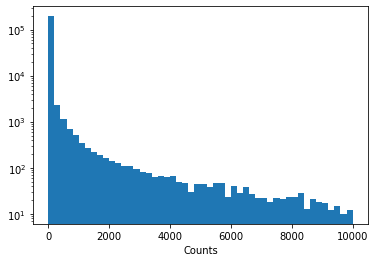

In [11]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# tokens = <YOUR CODE HERE>
tokens = [key for key in sorted(token_counts.keys()) if token_counts[key] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
# token_to_id = <your code here>
token_to_id = {tokens[i] : i for i in range(len(tokens))}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [20]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [21]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[10484, 12271,  2189, 27481, 12138, 26986, 18864,    82, 17043,
          3558],
        [ 4986,  9083, 11451, 12561,    16,  8352, 25511,   907,    82,
         18311],
        [14326, 21634,  5385,   197, 21436,  6444, 17744, 26009, 31100,
         16898]], dtype=int32),
 'Log1pSalary': array([10.71444 , 10.221977, 10.477316], dtype=float32),
 'Title': array([[10484, 12271,  2189, 27481, 12138, 26986, 18864,     1],
        [ 4986,  9083, 11451, 34100, 12561,    16,  8352,     1],
        [18864,  6444, 17744,   197, 14326, 21634,  5385, 28761]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [22]:
import torch, torch.nn as nn
import torch.nn.functional as F

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]    

In [23]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        h = self.conv1(h)
        # print(h.shape)
        h = self.pool1(h)
        # print(h.shape)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = torch.LongTensor(generate_batch(data_train, 3)['Title'])
dummy_v = title_encoder(dummy_x)

assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# <YOUR CODE HERE>

class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        copied from TitleEncoder, but changed embeddins size
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(128, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [ ]:
desc_encoder = DescriptionEncoder()

dummy_x = torch.LongTensor(generate_batch(data_train, 3)['FullDescription'])
dummy_v = desc_encoder(dummy_x)

assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        # <YOUR CODE>
        self.cat_dense1 = nn.Linear(n_cat_features, 64)
        self.cat_dense2 = nn.Linear(64, 64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        # <YOUR CODE>
        self.out1 = nn.Linear(192, 64)
        self.out2 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(p = 0.2)
        self.bnorm = nn.BatchNorm1d(64)
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_dense1(cat_features)
        cat_h = self.cat_dense2(F.relu(self.bnorm(cat_h)))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        # <YOUR CODE>
        h = self.out1(joint_h)
        h = self.dropout(h)
        h = self.out2(h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return h[:,0]

In [ ]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(34158, 64, padding_idx=1)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=64, out_features=64, bias=True)
  )
  (desc_encoder): DescriptionEncoder(
    (emb): Embedding(34158, 128, padding_idx=1)
    (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=64, out_features=64, bias=True)
  )
  (cat_dense1): Linear(in_features=3768, out_features=64, bias=True)
  (cat_dense2): Linear(in_features=64, out_features=64, bias=True)
  (out1): Linear(in_features=192, out_features=64, bias=True)
  (out2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
def batch_to_tensors(batch):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
    reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)
    return [title_ix, desc_ix, cat_features], reference

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

model_input, reference = batch_to_tensors(batch)

prediction = model(*model_input)

assert len(prediction.shape) == 1 and prediction.shape[0] == 32

In [ ]:
prediction

tensor([ 0.2578,  0.0654, -0.1491,  0.2688,  0.2369,  0.0832,  0.1121,  0.1094,
         0.2348, -0.0017,  0.0920, -0.0701,  0.1755,  0.1052,  0.3286,  0.0287,
         0.1131, -0.1249,  0.0681,  0.1228,  0.1228,  0.0892, -0.0770,  0.3700,
         0.3141,  0.3684,  0.1330,  0.2577, -0.0242,  0.1308,  0.2141,  0.1061],
       device='cuda:0', grad_fn=<SelectBackward>)

In [25]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [26]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [27]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [28]:
from IPython import display

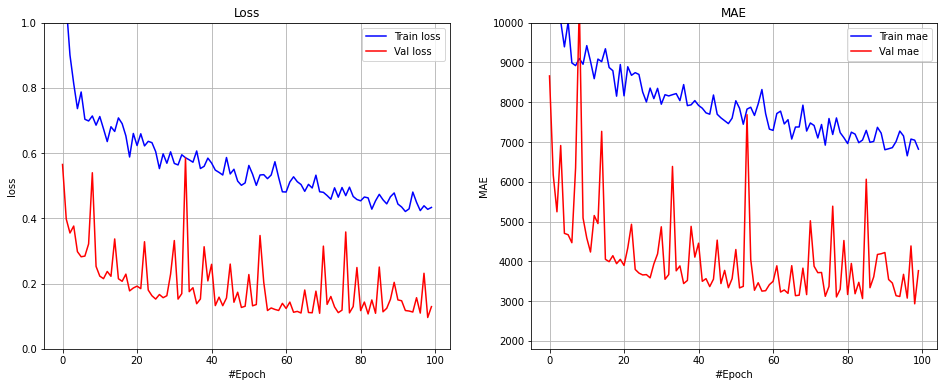

In [ ]:
history = [[], [], [], []]
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        model_input, reference = batch_to_tensors(batch)

        prediction = model(*model_input)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1
    
    history[0].append(train_loss / train_batches)
    history[1].append(train_mae / train_batches)
    print("\tLoss:\t%.5f" % (history[0][-1]))
    print("\tMAE:\t%.5f" % (history[1][-1]))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        model_input, reference = batch_to_tensors(batch)
        prediction = model(*model_input)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1     
        
    history[2].append(val_loss / val_batches)
    history[3].append(val_mae / val_batches)
          
    print("\tLoss:\t%.5f" % (history[2][-1]))
    print("\tMAE:\t%.5f" % (history[3][-1]))
    print('\n\n')
          
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(history[0], 'b', label='Train loss')
    ax1.plot(history[2], 'r', label='Val loss')
    #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()
    ax1.set_ylim(0, 1)

    ax2.set_title("MAE")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("MAE")
    ax2.plot(history[1], 'b', label='Train mae')
    ax2.plot(history[3], 'r', label='Val mae')
    #ax2.plot(ewma(np.array(val_loss), span=10),'r',label='ewm val acc')
    ax2.legend(loc='best')
    ax2.grid()    
    ax2.set_ylim(1800, 10000)

    plt.show()              

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    model_input, reference = batch_to_tensors(batch)

    prediction = model(*model_input)
    loss = compute_loss(reference, prediction)

    val_loss += loss.item()
    val_mae += compute_mae(reference, prediction).item()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':



	Loss:	0.12933
	MAE:	3764.17816





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa). The color to weight endcoding will be printed before the text.

In [39]:
def explain(model, sample, col_name='Title', max_len=None):
    """ Computes the effect each word had on model predictions """

    model.eval()
    sample = dict(sample)
    sample_tok = sample[col_name].split()

    batch = generate_batch( pd.DataFrame.from_dict(sample, orient = 'index', columns= ['']).transpose() , max_len = max_len)
        
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)

    # compute model prediction on sample (scalar float log-salary)
    baseline_pred =  float(model(title_ix, desc_ix, cat_features))
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = []
    
    if col_name=='Title':
      for i in range(title_ix.shape[1]):
        new_title_ix = title_ix.clone()
        new_title_ix[0][i] = 0
        predictions_without_word.append(float(model(new_title_ix, desc_ix, cat_features))) #<YOUR CODE>
    else:
      for i in range(desc_ix.shape[1]):
        new_title_ix = desc_ix.clone()
        new_title_ix[0][i] = 0
        predictions_without_word.append(float(model(title_ix, new_title_ix, cat_features)))
      
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]

    # return a list of pairs: [(token, score_difference)]
    return list(zip(sample_tok, score_differences)) #<YOUR CODE>

In [ ]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             70029181
Title                 deputy general managermulti branded retailermi...
FullDescription       our client is a hugely successful multi brande...
LocationRaw                                               East Midlands
LocationNormalized                                        East Midlands
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                                            CVUK
Category                                                    Retail Jobs
SalaryRaw             From 40,000 to 50,000 per annum Plus Bonus and...
SalaryNormalized                                                  45000
SourceName                                             retailchoice.com
Log1pSalary                                                     10.7144
Name: 127235, dtype: object
[('deputy', 0.055059432983398

In [40]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html



def weight_to_color(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=weight, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
i = np.random.randint(len(data))
sample = data.loc[i]

print("Index:", i)

tokens_and_weights = explain(model, sample, "Title")

tokens_and_weights = explain(model, sample, "Title")
weight_to_color([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:14px;');

draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 98255


-0.017347335815429688 -0.11790275573730469 0.20165443420410156 0.4108715057373047 0.3299427032470703 -0.022554397583007812 0.2642631530761719 0.01888275146484375 -0.400543212890625

office manager / data entry manager / archiving manager

office manager / data entry manager / archiving manager i require an experienced and credible manager to lead an established department on a long term fixed term contract the current project has been running for over 7 years and the successful candidate will have proven experience in leading teams or a department of target focused individuals your duties will include managing team leaders and team members to ensure data capture targets are acheived according to quantity and quality any experience gained in an archiving or records management environment would be highly desirable please contact me for further information office manager / data entry manager / archiving managerin accordance with the employment agencies and employment businesses regulations **** this position is advertised based upon dgh recruitment limited having first sought approval of its client to find candidates for this position . dgh recruitment limited acts as both an employment agency and employment business

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. Please, make experiments (below) with each point separately and then allgotether.


If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling (create a separate class for this one)

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

------------------------------------------

При прогоне базовой версии ноутбука с восполнением пропусков удалось достичь следующих значений метрик

Loss:	0.12933, MAE:	3764.17816

Довольно неплохо. Визуализация из 3 пункта, также это подтверждает.

Постараюсь улучшить результат за счет добавления трёх вещей:

1.   Другого пулинга
2.   Рекуррентного слоя
3.   Натренированного эмбединга



In [29]:
# 1. Далее в уже имеющейся модели заменю слои пулинга на этот класс

class GlobalSoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return (x * F.softmax(x, dim=self.dim)).sum(dim = self.dim)

In [30]:
# 2. В дескрипшенэнкодере заменил сверточный слой на gru

class DescriptionEncoderGRU(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        copied from TitleEncoder, but changed embeddins size
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        # self.conv1 = nn.Conv1d(128, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalSoftmaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.rnn = nn.GRU(128, 64, 2, batch_first = True)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h, hid = self.rnn(h)
        h = torch.transpose(h, 1, 2)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        # h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        # print(h)
        h = self.dense(h)
        return h

In [31]:
# 3. Скачал веса и создал свой эмбединг

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip -k GoogleNews-vectors-negative300.bin.gz

import gensim

google_news = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

emb = nn.Embedding(len(tokens), 300, padding_idx=PAD_IX)
for i, token in enumerate(tokens):
    if token in google_news:
        emb.weight.data[i] = torch.FloatTensor(google_news[token])

--2020-06-20 13:12:45--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.170.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.170.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  13.9MB/s    in 1m 57s  

2020-06-20 13:14:42 (13.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [32]:
# А тут в тайтл энкодере заменил слой эмбединга на прокачанный вариант

class TitleEncoderGoogleNews(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = emb
        self.conv1 = nn.Conv1d(300, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalSoftmaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        # <YOUR CODE>
        h = self.conv1(h)
        # print(h.shape)
        h = self.pool1(h)
        # print(h.shape)
        h = F.relu(h)
        h = self.dense(h)
        return h

In [33]:
# Тут ничего не менял

class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoderGoogleNews(out_size=64)
        self.desc_encoder = DescriptionEncoderGRU(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        # <YOUR CODE>
        self.cat_dense1 = nn.Linear(n_cat_features, 64)
        self.cat_dense2 = nn.Linear(64, 64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        # <YOUR CODE>
        self.out1 = nn.Linear(192, 64)
        self.out2 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(p = 0.2)
        self.bnorm = nn.BatchNorm1d(64)
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_dense1(cat_features)
        cat_h = self.cat_dense2(F.relu(self.bnorm(cat_h)))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        # <YOUR CODE>
        h = self.out1(joint_h)
        h = self.dropout(h)
        h = self.out2(h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return h[:,0]

In [34]:
# Это чисто для проверки было

# device = 'cpu'
# model = FullNetwork().to(device)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# model.title_encoder = TitleEncoderGoogleNews()
# model.desc_encoder = DescriptionEncoderGRU()
# model.title_encoder.pool1 = GlobalSoftmaxPooling()
# model.desc_encoder.pool1 = GlobalSoftmaxPooling()

# # test it on one batch
# batch = generate_batch(data_train, 32)
# model_input, reference = batch_to_tensors(batch)
# prediction = model(*model_input)
# assert len(prediction.shape) == 1 and prediction.shape[0] == 32



# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# Добавляю в имеющуюся модель 3 доработки
# model.title_encoder = TitleEncoderGoogleNews()
# model.desc_encoder = DescriptionEncoderGRU()
# model.title_encoder.pool1 = GlobalSoftmaxPooling()
# model.desc_encoder.pool1 = GlobalSoftmaxPooling()

In [35]:
model, device

(FullNetwork(
   (title_encoder): TitleEncoderGoogleNews(
     (emb): Embedding(34158, 300, padding_idx=1)
     (conv1): Conv1d(300, 64, kernel_size=(3,), stride=(1,), padding=(1,))
     (pool1): GlobalSoftmaxPooling()
     (dense): Linear(in_features=64, out_features=64, bias=True)
   )
   (desc_encoder): DescriptionEncoderGRU(
     (emb): Embedding(34158, 128, padding_idx=1)
     (pool1): GlobalSoftmaxPooling()
     (dense): Linear(in_features=64, out_features=64, bias=True)
     (rnn): GRU(128, 64, num_layers=2, batch_first=True)
   )
   (cat_dense1): Linear(in_features=3768, out_features=64, bias=True)
   (cat_dense2): Linear(in_features=64, out_features=64, bias=True)
   (out1): Linear(in_features=192, out_features=64, bias=True)
   (out2): Linear(in_features=64, out_features=1, bias=True)
   (dropout): Dropout(p=0.2, inplace=False)
   (bnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), device(type='cuda', index=0))

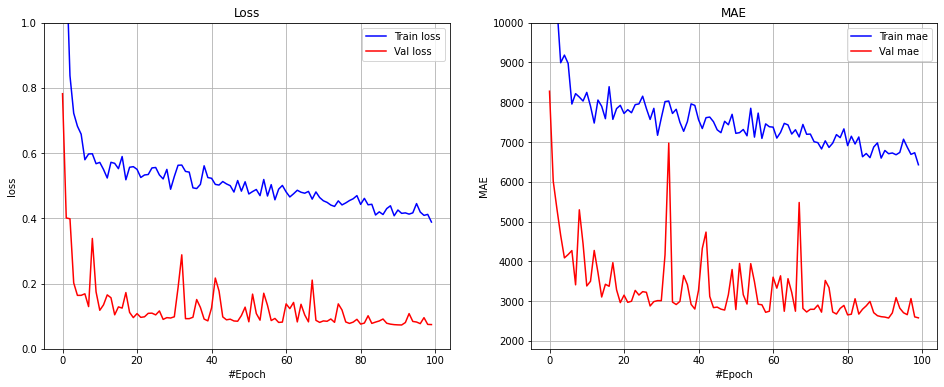

In [36]:
history = [[], [], [], []]
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        model_input, reference = batch_to_tensors(batch)

        prediction = model(*model_input)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1
    
    history[0].append(train_loss / train_batches)
    history[1].append(train_mae / train_batches)
    print("\tLoss:\t%.5f" % (history[0][-1]))
    print("\tMAE:\t%.5f" % (history[1][-1]))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        model_input, reference = batch_to_tensors(batch)
        prediction = model(*model_input)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1     
        
    history[2].append(val_loss / val_batches)
    history[3].append(val_mae / val_batches)
          
    print("\tLoss:\t%.5f" % (history[2][-1]))
    print("\tMAE:\t%.5f" % (history[3][-1]))
    print('\n\n')
          
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(history[0], 'b', label='Train loss')
    ax1.plot(history[2], 'r', label='Val loss')
    #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()
    ax1.set_ylim(0, 1)

    ax2.set_title("MAE")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("MAE")
    ax2.plot(history[1], 'b', label='Train mae')
    ax2.plot(history[3], 'r', label='Val mae')
    #ax2.plot(ewma(np.array(val_loss), span=10),'r',label='ewm val acc')
    ax2.legend(loc='best')
    ax2.grid()    
    ax2.set_ylim(1800, 10000)

    plt.show()              

In [37]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    model_input, reference = batch_to_tensors(batch)

    prediction = model(*model_input)
    loss = compute_loss(reference, prediction)

    val_loss += loss.item()
    val_mae += compute_mae(reference, prediction).item()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':



	Loss:	0.07428
	MAE:	2578.43611





In [41]:
i = np.random.randint(len(data))
sample = data.loc[i]

print("Index:", i)

tokens_and_weights = explain(model, sample, "Title")

tokens_and_weights = explain(model, sample, "Title")
weight_to_color([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:14px;');

draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 200553


-0.7693958282470703 -0.8360958099365234 -0.06814002990722656 -0.074462890625 -0.015850067138671875 -0.01171112060546875

senior manager product marketing risk compliance

practicus strategic hires are working with a leading international financial services provider with the appointment of a senior manager product , proposition , marketing , risk compliance which can be based in either london , dorking or salisbury . working as part of an already established team you will be the first line of defence within strategy , proposition development , branding and marketing ensuring a culture of risk control is embedded within the heart of the team . you will provide clear accountability within the team for regulatory compliance ensuring that applicable regulations are in place and processes are compliant . you will take an overview to ensure all printed documents or online material destined for customers or distributors are checked and validated inline with the relevant geographical regulatory bodies . as such the successful candidate will need to interpret the rules and regulatory requirements in the appropriate jurisdictions and oversee the checking and final sign off of all sales aids , literature both on and offline . it will be imperative that you support the department in ensuring that a complete library is maintained of all marketing literature online and print globally . the teams based in the various international locations will need to take ownership of their own regions however this role is seen as pivotal to ensuring this is done . you will need to work closely with group risk , compliance and international risk oh behalf of the strategy , proposition development , branding and marketing team to ensure a consistent approach and planning audit actions accordingly . in order to be considered for this position you will need to have a detailed understanding of regulatory requirements of multiple jurisdictions as they relate to marketing materials . you will need to demonstrate an extensive experience gained in either a financial compliance or regulatory risk environment ideally within a financial product provider environment . you will ideally have had international experience within at least one of the following nonuk regulators : hong kong , singapore , uae , europe freedom of service or large countries within latin america . this is an excellent opportunity to take a lead role within an international financial services provider and embed a risk control culture at the very heart of their key products and marketing material .

Результаты значительно улучшились.

Теперь мы имеем Loss:	0.07428, MAE:	2578.43611 вместо Loss: 0.12933, MAE: 3764.17816

В идеале бы всё это тестировать по очереди, чтобы оценить вклад каждой доработки, но колаб непостоянен, и надо еще выполнить несколько ноутбоков с заданиями. 